## Import Packages

In [1]:
# Import packages
%matplotlib inline

from surprise import Reader
from surprise import SVD,SVDpp, NMF
from surprise import KNNBasic
from surprise import Dataset
from surprise import Trainset
from surprise import accuracy
from surprise.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from itertools import combinations
from collections import defaultdict
import random
import copy
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
np.random.seed(0)
random.seed(0)
warnings.filterwarnings('ignore')

## Define Working Directory

In [3]:
# path_clean_data = '/Users/jericojohns/Desktop//W207/W207_movies/data/clean_data/'

## Import Prepocessed Data 

#### TEMPORARY SECTION. 

In [4]:
def filter_ratings(df, min_ratings):
    
    '''Filter users with num_ratings below min_ratings
    params: df, min_ratings
    return: sorted_filtered_df
    '''
    
    # Value counts of user ratings
    user_ratings_counts = df['userId'].value_counts()
    # List of users with ratings counts greater than min_ratings
    filtered_users = user_ratings_counts[user_ratings_counts >= min_ratings].index
    # Filter df to list of users above
    filtered_df = df[df['userId'].isin(filtered_users)]
    
    return filtered_df

In [5]:
def train_dev_test_split(ratings_df, dev_size=1, test_size=1):
    
    '''
    Split user ratings data into train, development and test sets holding the last 
    [test_size] ratings per user for test and last [dev_size] ratings per user for 
    development, following reverse chronological order
    
    Parameters
    ----------
    ratings_df : A dataframe of ratings data
    dev_size : The number of ratings per user to set asside development data
    test_size : The number of ratings per user to set asside test data
    
    Returns
    -------
    train_df : Dataframe of training ratings data
    dev_df : Dataframe of development ratings data
    test_df :  Dataframe of test ratings data
    '''
    
    # Add a column that ranks each rating in reverse chronolgical grouped by user
    ratings_df['rank'] = ratings_df.groupby(['userId'])['timestamp'] \
                         .rank(method='first', ascending=False).copy()
    
    # Filter to test data using rank column
    test_df = ratings_df[ratings_df['rank'].isin(range(1,1+test_size))][['userId', 'movieId', 'rating']]
    
    # Filter to dev data using rank column
    dev_df = ratings_df[ratings_df['rank'].isin(range(1+test_size, 1+test_size+dev_size))][['userId', 'movieId', 'rating']]
    
    # Filter to train data using rank column
    train_df = ratings_df[ratings_df['rank'] >= (1+test_size+dev_size)][['userId', 'movieId', 'rating']]
        
    return train_df, dev_df, test_df

In [6]:
def create_evaluation_pools(train_df, test_df, pool_size=100):
    
    '''
    Create pools of movies to evaluate the collaborative filtering models.
    Each pool will contain pool_size movies per user. Each pool includes the 
    movies in the test_df and randomly selects the rest of the movies from 
    those not watched by the user.
    
    Parameters
    ----------
    train_df : A dataframe of the training ratings data
    test_df : A dataframe of the test ratings data
    pool_size : The size of each movie pool
    
    Returns
    -------
    evaluation_pools_dict : A dictionary from user to the pool of movies on 
                            which to evaluate the recommender system
    
    '''
    
    # Find the list of unique users and movies in the training data
    users = set(train_df['userId'].unique())
    movies = set(train_df['movieId'].unique())
    
    # Instantiate the output dictionary
    evaluation_pools_dict = {}
    
    # Loop through each user
    for user in users:
        
        # Find set of movies rated by the user in the training and test data
        train_movies = set(train_df[train_df['userId']==user]['movieId'])
        test_movies = set(test_df[test_df['userId']==user]['movieId'])
        
        # Find the set of movies not rated by the user
        movies_not_rated = movies - train_movies - test_movies
        
        # Randomly sample movies from the movies not rated by the user
        n_movies_to_choose = pool_size - len(test_movies)
        sample_movies_not_rated = set(random.sample(movies_not_rated, n_movies_to_choose))
        
        # Combine the test movies with the random sample of movies
        evaluation_pool = list(test_movies | sample_movies_not_rated)
        
        # Add each evaluation_pool to the output dictionary 
        evaluation_pools_dict[user] = evaluation_pool
    
    return evaluation_pools_dict

In [7]:
#Load data into ratings_df. 
ratings_df = pd.read_csv("/Users/jericojohns/Desktop/W207/data/ratings_small.csv", low_memory=False)

In [8]:
#TEMPORARY
#Filter our user list to those users who have 30+ ratings
filtered_data = filter_ratings(ratings_df, min_ratings = 30)

#Now split our data so that we take the n-1 (most recent) rating as our test rating, 
#and n-2 (second most recent) rating as our dev rating 
train_df, dev_df, test_df = train_dev_test_split(filtered_data)

dev_evaluation_pools = create_evaluation_pools(train_df, dev_df)

#Create a surprise Reader object to help us create a Surprise DataSet object. 
reader = Reader()

#Now we load training data as is (no folding) by calling the .build_full_trainset() method. 
train_data = Dataset.load_from_df(train_df, reader).build_full_trainset()


#Convert dev_data to DataSet object, and then as testset object by calling .buildtestset()
dev_data = Dataset.load_from_df(dev_df, reader).build_full_trainset()
dev_data = dev_data.build_testset()

#Convert test_data to DataSet object, and then as testset object by calling .buildtestset()
test_data = Dataset.load_from_df(test_df, reader).build_full_trainset()
test_data = test_data.build_testset()

In [9]:
# Load train, dev, test data
# train_df = pd.read_csv(path_clean_data + "cf_train_ratings.csv", low_memory=False)
# dev_df = pd.read_csv(path_clean_data + "cf_dev_ratings.csv", low_memory=False)
# test_df = pd.read_csv(path_clean_data + "cf_test_ratings.csv", low_memory=False)

In [10]:
# drop 'Unnamed 0' column
# train_df.drop('Unnamed: 0', axis=1, inplace=True)
# dev_df.drop('Unnamed: 0', axis=1, inplace=True)
# test_df.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
# Inspect train_df
train_df.head()

,userId,movieId,rating
20,2,10,4.0
21,2,17,5.0
22,2,39,5.0
23,2,47,4.0
24,2,50,4.0


In [12]:
# Load dev and test evaluation pools
# f1 = open(path_clean_data + 'dev_evaluation_pools.json',)
# f2 = open(path_clean_data + 'test_evaluation_pools.json',)
# dev_evaluation_pools = json.load(f1)
# test_evaluation_pools = json.load(f2)

# # Convert key from str to int
# dev_evaluation_pools = {int(k):v for k,v in dev_evaluation_pools.items()}
# test_evaluation_pools = {int(k):v for k,v in test_evaluation_pools.items()}

## Load Data into Surprise Data Structures

In [13]:
#Create a surprise Reader object to help us create a Surprise DataSet object. 
reader = Reader()

#Now we load training data as is (no folding) by calling the .build_full_trainset() method. 
train_data = Dataset.load_from_df(train_df, reader).build_full_trainset()

#Convert dev_data to DataSet object, and then as testset object by calling .buildtestset()
dev_data = Dataset.load_from_df(dev_df, reader).build_full_trainset()
dev_data = dev_data.build_testset()

#Convert test_data to DataSet object, and then as testset object by calling .buildtestset()
test_data = Dataset.load_from_df(test_df, reader).build_full_trainset()
test_data = test_data.build_testset()

## Run and Evaluate Matrix Factorization Models

### Define Custom Functions

In [14]:
def calculateItemNovelty(ratings_df):
    '''Create two lists of 1.) sc_rankings (standardized and minMaxScaled)
    and 2.) movieIDs that correspond to those rankings.'''
    rankings = ratings_df["movieId"].value_counts()
    ratings =  ratings_df[['movieId','rating']].groupby('movieId').mean()

    #Let's standardize our rankings to be able to be used together 
    scaler = MinMaxScaler(feature_range = (0,5))
    scaler2 = RobustScaler()
    ranking_movieID = rankings.index.to_numpy()
    ratings = ratings.to_numpy().reshape(-1,1)

    scaler.fit(ratings)
    scaler2.fit(ratings)
    sc_rankings = rankings.to_numpy().reshape(-1,1)
    sc_rankings = scaler2.transform(sc_rankings)
    sc_rankings = scaler.fit_transform(sc_rankings)



    sc_rankings = sc_rankings.tolist()

    sc_rankings = [(float(i[0])*-1)+5 for i in sc_rankings]


    ranking_movieID = ranking_movieID.tolist()
    
    return sc_rankings, ranking_movieID

In [15]:
def sort_evaluation_pools(model, evaluation_pools, ranking_list, ranking_movies):
    '''
    Take evaluation pool for each user and sort it based on ratings predicted by a 
    trained model in descending order of predicted ratings
    Parameters
    ----------
    model : A trained surprise model
    evaluation_pools : A dictionary from user to the pool of movies on 
                       which to evaluate the recommender system 
    ranking_list = movie novelty scores
    ranking_movies = movieIDs tied to novelty scores
    
    Returns
    -------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    '''
    
    # Instantiate output dictionary
    sorted_evaluation_pools = {}
    
    # Loop through each key-value pair in the input dictionary
    for user, movie_pool in evaluation_pools.items():
        
        # Create a dictionary for the predicted rating of each movie in the user's pool
        predictions = {}
        for movie in movie_pool:
            pred = model.predict(user, movie)
            try: 
                novelty = ranking_list[ranking_movies.index(movie)]
            except: 
                novelty = 5
            predictions[movie] = (pred[3],novelty)
            #Add in the novelty score
            
        
        # Sort the pool in descending order of predicted ratings
        sorted_pool = [(k,v) for k, v in sorted(predictions.items(), key=lambda item: item[1], reverse=True)]
        
        # Add key-value pair of user and sorted evalualtion pool to the output dictionary
        sorted_evaluation_pools[user] = sorted_pool
        
        #Finally reformat our dictionary to be in format userID: (movieID, rating, novelty)
        final_pool = defaultdict(list)
        for userID in sorted_evaluation_pools: 
            for movieID, tup in sorted_evaluation_pools[userID]: 
                final_pool[int(userID)].append((int(movieID), tup[0], tup[1]))


    return final_pool

In [16]:
def calc_hit_rate_pools(sorted_evaluation_pools, test_df, top_n=10):
    '''
    Calculate hit rate given a dictionary of sorted evaluation pools and the corrsponding 
    test data frame. A hit is defined as finding a test movie in the top_n of sorted 
    evalutation pool of a user
    Parameters
    ----------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    test_df : A dataframe of ratings for movies being tested in the evaluation pools
    top_n : The threshold above which a test movies should be found to be called a hit
    
    Returns
    -------
    hit_rate : A hit rate across pools
    
    '''
    
    # Start with hits and totals at 0
    hits=0
    total=0
    
    # Loop through the each key-value pair in the input dictionary
    for user, sorted_pool in sorted_evaluation_pools.items():
        
        # Filter to test movies for the user
        test_movies = test_df[test_df['userId']==user]
        
        # Find top_n movies from the pool
        top_movies = sorted_pool[:top_n]
        
        # Loop through each test movie
        for index, test_movie in test_movies.iterrows():
            test_movie_id = test_movie['movieId']
            
            # If test movie is in top_movies, then add one to hits
            for movie, rating, novelty in top_movies: 
                if test_movie_id == movie:
                    hits += 1
                
            # Add one to total for each test movie  
            total += 1
     
    hit_rate = hits/total
    return hit_rate

In [17]:
def calc_hit_rate_pools_with_cutoff(sorted_evaluation_pools, test_df, top_n=10, rating_cutoff=0):
    '''
    Calculate hit rate given a dictionary of sorted evaluation pools and a corresponding 
    test data frame. A hit is defined as finding a test movie that has a rating greater 
    than a rating_cutoff in the top_n of sorted evalutation pool of a user.
    Parameters
    ----------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    test_df : A dataframe of ratings for movies being tested in the evaluation pools
    top_n : The threshold above which a test movies should be found to be called a hit
    rating_cutoff : The threshold rating above which a test movie should be evaluated
    
    Returns
    -------
    hit_rate : A hit rate across pools
    '''
    
    # Start with hits and totals at 0
    hits=0
    total=0
    
    # Loop through the each key-value pair in the input dictionary
    for user, sorted_pool in sorted_evaluation_pools.items():
        
        # Filter to test movies for the user
        test_movies = test_df[test_df['userId']==user]

         # Find top_n movies from the pool
        top_movies = sorted_pool[:top_n]
        
        # Loop through each test movie
        for index, test_movie in test_movies.iterrows():
            test_movie_rating = test_movie['rating']
            test_movie_id = test_movie['movieId']
            
             # If test movie has a rating above rating_cutoff then evaluate
            if test_movie_rating >= rating_cutoff:
                
                # If test movie is in top_movies, then add one to hits
                # If test movie is in top_movies, then add one to hits
                for movie, rating, novelty in top_movies: 
                    if test_movie_id == movie:
                        hits += 1
                
                # Add one to total for each test movie
                total += 1

    return hits/total

In [18]:
def summaryStats(sorted_evaluation_pools, test_df, rating_cutoff = 4): 
    '''Calculate average novelty, average rating, and hit rate for the top 10 of final sorted_evaluation_pool.'''
    hit_rate_pools = calc_hit_rate_pools(sorted_evaluation_pools, test_df)
    hit_rate_pools_with_cutoff =  calc_hit_rate_pools_with_cutoff(sorted_evaluation_pools, test_df, rating_cutoff=rating_cutoff)
    
    total_est_rating = 0 
    total_novelty = 0 
    total_items = 0 
    for userID in sorted_evaluation_pools.keys(): 
        for tup in sorted_evaluation_pools[userID][:10]: 
            total_est_rating += tup[1]
            total_novelty += tup[2]
            total_items += 1
    
    avg_est_rating  = total_est_rating / total_items
    avg_novelty = total_novelty / total_items
    
    return hit_rate_pools, hit_rate_pools_with_cutoff, avg_est_rating, avg_novelty 
        


In [19]:
def compareModels(models, train_data, dev_data): 
    '''For baseline model selection of matrix factorization models.
    Choose model that optimizes hit_rate_pools_with_cutoff.'''
    for algo in models: 
        #Print model type 
        print(type(algo).__name__)
        
        #Train our train_data (all user's that have liked 30+ movies, train on the n-2 movie set)
        algo.fit(train_data)
        
        #Sort our evaluation pool, using the algo. 
        sorted_dev_evaluation_pools = sort_evaluation_pools(algo, dev_evaluation_pools,sc_rankings, ranking_movieID) 
        
        #Calculate summary stats for each model. 
        hit_rate_pools, hit_rate_pools_with_cutoff, avg_est_rating, avg_novelty = summaryStats(sorted_dev_evaluation_pools, dev_df, rating_cutoff = 4)
        print(f'HR@10: {hit_rate_pools}')
        print(f'HR@10 w/ Cutoff: {hit_rate_pools_with_cutoff}')
        print(f'AvgRating@10: {avg_est_rating}')
        print(f'AvgNovelty@10: {avg_novelty}')

In [20]:
def bestHyperparams(n_factors, n_epochs, lr_all, reg_all): 
    '''Non-exhaustive (manual) search over hyperparam values to
    select the best hyperparam values for hit_rate_pools_with_cutoff.'''
    best_hr = 0
    best_n_factors = 0
    best_n_epochs = 0 
    best_lr_all = 0 
    best_reg_all = 0

    for n_factor in n_factors: 
        for n_epoch in n_epochs: 
            for lr in lr_all: 
                for reg in reg_all: 
                    algo = SVD(n_factors = n_factor, n_epochs = n_epoch, lr_all = lr, reg_all = reg)
                    algo.fit(train_data)
                    sorted_dev_evaluation_pools = sort_evaluation_pools(algo, dev_evaluation_pools, sc_rankings, ranking_movieID)
        

                    #Calculate the two hit rates
                    hit_rate_pools = calc_hit_rate_pools(sorted_dev_evaluation_pools, dev_df)
                    hit_rate_pools_with_cutoff = calc_hit_rate_pools_with_cutoff(sorted_dev_evaluation_pools, dev_df, rating_cutoff=4)

                    if hit_rate_pools_with_cutoff > best_hr: 
                        best_hr = hit_rate_pools_with_cutoff
                        best_n_factors = n_factor
                        best_n_epochs = n_epoch
                        best_lr_all = lr
                        best_reg_all = reg


    print(f'Best HR@10: {best_hr}')
    print(f'n_factors = {best_n_factors}, n_epochs = {best_n_epochs}, lr_all = {best_lr_all}, reg_all = {best_reg_all}')
    
    return best_n_factors, best_n_epochs, best_lr_all, best_reg_all


In [21]:
def GetTopNSplitPools(sorted_evaluation_pool):
    '''Get the top n predicted movie ratings for a given user, 
    the next n, and the rest of the evaluation pool. 
    Used to process sorted_evaluation_pool before 
    diversificationSwap().'''
    predictions = sorted_evaluation_pool
    topN = defaultdict(list)
    nextN = defaultdict(list)
    remainingN = defaultdict(list)
    
    #Select top_n and remaining_n
    for userID, movies in predictions.items():
        topN[int(userID)] = movies[:10]
        #Pull the next n items as the remainingN list 
        nextN[int(userID)] = movies[10:30]
        remainingN[int(userID)] = movies[30:]
        

    return topN, nextN, remainingN

In [22]:
def diversificationSwap(topNPredicted, nextNPredicted, remainingNPredicted, iterations = 1): 
    '''For iteration in desired number of iterations (hyperparam): 
    drop the lowest novelty item from the topN list and
    replace with the highest novelty item from the remainingN list.'''
    
    topNPredicted_temp = copy.deepcopy(topNPredicted)
    nextNPredicted_temp = copy.deepcopy(nextNPredicted)
    
    for i in range(iterations): 
        for userID in topNPredicted_temp.keys():
            #Create a boolean that indicates whether swap is found
            swap_top = False
            
            #Drop items from topN and add to remainingN
            min_ranking = 5 
            min_movieID = None
            min_rating = None
            
            for item in topNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                
                if rank < min_ranking: 
                    swap_top = True
                    min_ranking = rank
                    min_movieID = movieID
                    min_rating = rating
                    
                    
            #Now shuffle (only if swap is found)
            if swap_top == True: 
                nextNPredicted_temp[int(userID)].append((int(min_movieID), min_rating, min_ranking))
                topNPredicted_temp[int(userID)].remove((int(min_movieID), min_rating, min_ranking))
            
            #Create a boolean that indicates whether swap is found
            swap_bottom  = False
            
            #Add items to topN and drop from remainingN
            max_ranking = 0 
            max_movieID = None
            max_rating = None
            
            for item in nextNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                
                if rank > max_ranking: 
                    swap_bottom = True
                    max_ranking = rank
                    max_movieID = movieID
                    max_rating = rating
                    
            #Now shuffle (only if swap is found)
            if swap_bottom == True: 
                topNPredicted_temp[int(userID)].append((int(max_movieID), max_rating, max_ranking))
                nextNPredicted_temp[int(userID)].remove((int(max_movieID), max_rating, max_ranking))
    
    #Now drop the ranking as this isn't needed for hit rate calcs. 
    #topNPredicted_temp.update(item[:-1] for item in value[items] for value in topNPredicted_temp.values())
    #remainingNPredicted_temp.update(item[:-1] for item in value[items] for value in remainingNPredicted.values())
    final_sorted_pool = defaultdict(list)
    
    #Add the top predicted, diversified items to our final evaluation_pool
    for userID in topNPredicted_temp.keys(): 
        for item in topNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the next N 
    for userID in nextNPredicted_temp.keys(): 
        for item in nextNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the remaining (unswapped) N items to create the full diversified evaluation pool 
    for userID in remainingNPredicted.keys(): 
        for item in remainingNPredicted[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
        
    return final_sorted_pool
        

In [23]:
def diversificationSwapBlended(topNPredicted, nextNPredicted, remainingNPredicted, iterations = 1, w1 = 0.5, w2 = 0.5): 
    '''For iteration in desired number of iterations (hyperparam): 
    drop the lowest blended rating and novelty item from the topN list and
    replace with the highest blended rating and novelty item from the remainingN list.
    This methods approximate's a movie's 'Hidden Gem' score (i..e high rating, low ranking)'''
    
    
    topNPredicted_temp = copy.deepcopy(topNPredicted)
    nextNPredicted_temp = copy.deepcopy(nextNPredicted)
    
    for i in range(iterations): 
        for userID in topNPredicted_temp.keys():
            #Create a boolean that indicates whether swap is found
            swap_top = False
            
            #Drop items from topN and add to remainingN
            min_blended_rank = 5
            min_movieID = None
            min_rating = None
            
            for item in topNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                blended_rank = (w1*rating) + (w2*rank)
                
                if blended_rank < min_blended_rank: 
                    swap_top = True
                    min_blended_rank = blended_rank
                    min_movieID = movieID
                    min_ranking = rank
                    min_rating = rating
                    
                    
            #Now shuffle (only if swap is found)
            if swap_top == True: 
                nextNPredicted_temp[int(userID)].append((int(min_movieID), min_rating, min_ranking))
                topNPredicted_temp[int(userID)].remove((int(min_movieID), min_rating, min_ranking))
            
            #Create a boolean that indicates whether swap is found
            swap_bottom  = False
            
            #Add items to topN and drop from remainingN
            max_blended_rank = 0 
            max_movieID = None
            max_rating = None
            
            for item in nextNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                blended_rank = (w1*rating) + (w2*rank)
                
                if blended_rank > max_blended_rank: 
                    swap_bottom = True
                    max_blended_rank = blended_rank
                    max_ranking = rank
                    max_movieID = movieID
                    max_rating = rating
                    
            #Now shuffle (only if swap is found)
            if swap_bottom == True: 
                topNPredicted_temp[int(userID)].append((int(max_movieID), max_rating, max_ranking))
                nextNPredicted_temp[int(userID)].remove((int(max_movieID), max_rating, max_ranking))
    
    #Now drop the ranking as this isn't needed for hit rate calcs. 
    #topNPredicted_temp.update(item[:-1] for item in value[items] for value in topNPredicted_temp.values())
    #remainingNPredicted_temp.update(item[:-1] for item in value[items] for value in remainingNPredicted.values())
    final_sorted_pool = defaultdict(list)
    
    #Add the top predicted, diversified items to our final evaluation_pool
    for userID in topNPredicted_temp.keys(): 
        for item in topNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the next N 
    for userID in nextNPredicted_temp.keys(): 
        for item in nextNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the remaining (unswapped) N items to create the full diversified evaluation pool 
    for userID in remainingNPredicted.keys(): 
        for item in remainingNPredicted[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
        
    return final_sorted_pool

In [24]:
def calcDiversityTradeoff(topNPredicted_Split, nextNPredicted_Split,remainingNPredicted_Split, dev_df):
    '''Plot our novelty / HR@10 tradeoff by increasing number of iterations of our 
    diversificationSwap.'''
    method = []
    average_novelty = [] 
    hit_rate = [] 

    method_blended = []
    average_novelty_blended = []
    hit_rate_blended = []

    hit_rate_cutoff = []
    hit_rate_cutoff_blended = [] 

    swapping_iterations = []
    swapping_iterations_blended = []

    for i in range(0,20): 
        diversified_evaluation_pools = diversificationSwap(topNPredicted_Split, nextNPredicted_Split, remainingNPredicted_Split, iterations = i)
        diversified_evaluation_pools_blended = diversificationSwapBlended(topNPredicted_Split, nextNPredicted_Split, remainingNPredicted_Split, iterations = i, w1 = 0.7, w2 = 0.3)
        hit_rate_diversified_pools, hit_rate_diversified_pools_with_cutoff, avg_est_rating, avg_novelty = summaryStats(diversified_evaluation_pools, dev_df, rating_cutoff = 4)
        hit_rate_diversified_pools_blended, hit_rate_diversified_pools_with_cutoff_blended, avg_est_rating_blended, avg_novelty_blended = summaryStats(diversified_evaluation_pools_blended, dev_df, rating_cutoff = 4)
        model = 'Matrix Factorization with SVD()'
        blended_model = 'Matrix Factoriziation with SVD(), blended swapping'

        method.append(model)
        method_blended.append(model)

        average_novelty.append(avg_novelty)
        average_novelty_blended.append(avg_novelty_blended)

        swapping_iterations.append(i)
        swapping_iterations_blended.append(i)

        hit_rate.append(hit_rate_diversified_pools)
        hit_rate_blended.append(hit_rate_diversified_pools_blended)

        hit_rate_cutoff.append(hit_rate_diversified_pools_with_cutoff)
        hit_rate_cutoff_blended.append(hit_rate_diversified_pools_with_cutoff_blended)

    
    return method, average_novelty, hit_rate, method_blended, average_novelty_blended, hit_rate_blended, swapping_iterations, swapping_iterations_blended

### Matrix Factorization Process

#### 1.) Calculate Item Novelty. 
##### We will use this in our sorted_evaluation_pools so that we don't need to pull-in novelty data everytime. 

In [25]:
#Calculate item (movieID) novelty. Store in 2 lists. 
sc_rankings, ranking_movieID = calculateItemNovelty(train_df)

(array([2.000e+00, 3.000e+00, 6.000e+00, 1.200e+01, 1.900e+01, 3.100e+01,
        8.300e+01, 1.330e+02, 4.450e+02, 8.266e+03]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

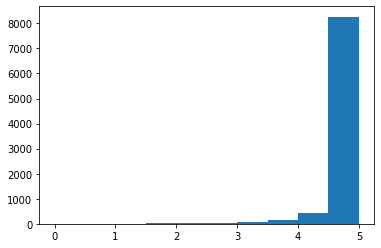

In [26]:
#View distribution
plt.hist(sc_rankings)

#### 2.) Test a baseline SVD() Model. 

In [27]:
# Train and test algorithm (Matrix Factorization for Collaborative Filtering)
algo = SVD()

# Train our train_data (all user's that have liked 30+ movies, train on the n-2 movie set)
algo.fit(train_data)

# Sort dev evaluation pools based on SVD model
sorted_dev_evaluation_pools = sort_evaluation_pools(algo, dev_evaluation_pools, sc_rankings, ranking_movieID)

#Get summary statistics that we will use across all models. 
hit_rate_pools, hit_rate_pools_with_cutoff, avg_est_rating, avg_novelty = summaryStats(sorted_dev_evaluation_pools, dev_df, rating_cutoff = 4)

print(f'HR@10: {hit_rate_pools}')
print(f'HR@10 w/ Cutoff: {hit_rate_pools_with_cutoff}')
print(f'AvgRating@10: {avg_est_rating}')
print(f'AvgNovelty@10: {avg_novelty}')

HR@10: 0.31103074141048825
HR@10 w/ Cutoff: 0.40192926045016075
AvgRating@10: 3.9996365688291933
AvgNovelty@10: 4.522305489868736


#### 3.) Compare the three predominant Matrix Factorization Models. 

In [28]:
#Specify the 3 models
models = [SVD(), SVDpp(), NMF()]
#Compare the 3 models. 
compareModels(models, train_data, dev_data)

SVD
HR@10: 0.3291139240506329
HR@10 w/ Cutoff: 0.41479099678456594
AvgRating@10: 3.995915633896061
AvgNovelty@10: 4.524826702832989
SVDpp
HR@10: 0.3092224231464738
HR@10 w/ Cutoff: 0.3858520900321543
AvgRating@10: 4.0227980601485775
AvgNovelty@10: 4.552739718087777
NMF
HR@10: 0.14466546112115733
HR@10 w/ Cutoff: 0.17684887459807075
AvgRating@10: 4.411594745103863
AvgNovelty@10: 4.799262182964616


#### 4.) Do a non-exhaustive search for the best baseline model (SVD) hyperarameters. 

In [29]:
#Note default values n_factors = 100, n_epochs = 20, lr_all = 0.005, reg_all = 0.02
n_factors = [50, 100, 200, 500]
n_epochs = [10,20,30]
lr_all = [0.001, 0.005, 0.01]
reg_all = [0, 0.01, 0.02, 0.04]

best_n_factors, best_n_epochs, best_lr_all, best_reg_all = bestHyperparams(n_factors, n_epochs, lr_all, reg_all)

Best HR@10: 0.4919614147909968
n_factors = 50, n_epochs = 10, lr_all = 0.005, reg_all = 0.04


#### 5.) Apply our best hyperparams to our best baseline model. 

In [30]:
#Return the first 10 movies (in predicted rating) from the evaluation_pool, 
#and then the remaining n. We will use this structure to swap our predictions for diversity. 
algo = SVD(n_factors = best_n_factors, n_epochs = best_n_epochs, lr_all = best_lr_all, reg_all = best_reg_all)
algo.fit(train_data)
sorted_dev_evaluation_pool = sort_evaluation_pools(algo, dev_evaluation_pools,sc_rankings, ranking_movieID)

#### 6.) Setup our diversification swapping. 

In [31]:
#Need to pass algo so that we can build the proper dictionary with predictions
topNPredicted_Split, nextNPredicted_Split, remainingNPredicted_Split = GetTopNSplitPools(sorted_dev_evaluation_pool)

#### 7.) Run our diversification swapping and plot tradeoff. 

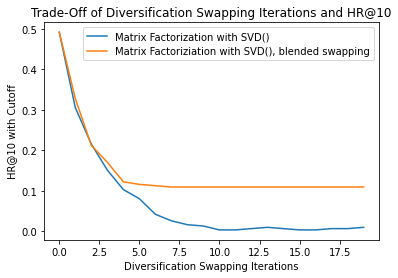

In [32]:
method, average_novelty, hit_rate, method_blended, average_novelty_blended, hit_rate_blended, swapping_iterations, swapping_iterations_blended = calcDiversityTradeoff(topNPredicted_Split, nextNPredicted_Split,remainingNPredicted_Split, dev_df)

plt.plot(swapping_iterations, hit_rate_cutoff, label = 'Matrix Factorization with SVD()')
plt.plot(swapping_iterations_blended, hit_rate_cutoff_blended, label = 'Matrix Factoriziation with SVD(), blended swapping')
plt.title("Trade-Off of Diversification Swapping Iterations and HR@10")
plt.xlabel("Diversification Swapping Iterations")
plt.ylabel("HR@10 with Cutoff")
plt.legend(loc = 'best')